<img src="PillowLogo.jpg" width="400">

# Hands-On Lab: Home Price Estimation

## Introduction
In this lab, PACCAR is entering the real estate market and taking on Zillow! We will be estimating home prices, showing how good data and good science get us the best recommendations. Specifically, we'll walk through:
* A simple linear regression
* AutoML
* Data understanding & feature engineering

In [1]:
# Import any packages we will need to use for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import yaml

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import power_transform

from scipy import stats

## Import Data
When working in code, we first need to import our data. This can come from databases, spreadsheets, websites, etc.

```
[!] It is important to remember that data is loaded into your computer's memory. When people talk about "Big Data", it is commonly describing datasets that don't fit into memory!
```

In [2]:
# Read in our dataset and investigate the first several rows
home_data = pd.read_csv("../Data/Train.csv")
home_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We should start by getting familiar with the dataset. Some common questions (and answers):

In [3]:
# What is our target variable?
print("SalePrice")
home_data.SalePrice.head(3)

SalePrice


0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64

In [4]:
# How many rows of data do we have?
print('Number of rows: {}'.format(len(home_data)))

Number of rows: 1460


In [5]:
# How many attributes do we have for each row of data? What are the features?
print('Number of columns: {}'.format(home_data.shape[1]))
print(list(home_data))

Number of columns: 81
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'

Thankfully, the city of Ames, Iowa does a terrific job of cataloging data. Have a look at *./Documentation/data_description.txt* for more information about what these inputs mean. Unfortunately, this is a rare treat but a state we should strive for.

In [6]:
# What data types are the features?
home_data.columns.to_series().groupby(home_data.dtypes).groups

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

## Measuring Quality
A strong suite of validation measures is critical to the success of an ML deployment.

For home pricing, we will use RMSE- Root Mean Square Error. 
<img src="rmse.jpg" width="400">
RMSE is commonly used in regression. We often communicate MAE (Mean Absolute Error), as it is more intuitive, but RMSE generally makes a better measure for maximizing model performance. The reason why is in the square term. RMSE penalizes larger errors more severely than smaller errors. 

For home pricing, we apply a small variation on RMSE, which is to measure the difference in the Logs of the prices. This is to assign equal weight to lower and higher priced homes.

```
[!] Plot Twist: This dataset comes from a public competition, for which there is a leaderboard! Throughout the lab, we will compare our performance against the leaderboard.
```

In [7]:
# Define RMSE formula to be used later
def getRMSE(data, target, prediction):
    data['num'] = (np.log(data[prediction]) - np.log(data[target]))**2
    RMSE = np.sqrt(sum(data.num) / len(data))
    RMSE
    return(RMSE)

Next chunk imports the leaderboard. Inspecting the scores shows 0.6626 is the score to beat, with most scores significantly under 1.

In [8]:
# Import leaderboard
leaderboard = pd.read_csv("../Data/house-prices-advanced-regression-techniques-publicleaderboard.csv")

# Sort by score
leaderboard = leaderboard.sort_values('Score')
leaderboard.Score.describe()

count    14429.000000
mean         0.377056
std          2.367223
min          0.066260
25%          0.123860
50%          0.140760
75%          0.173740
max        136.042180
Name: Score, dtype: float64

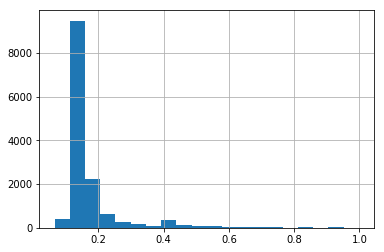

In [9]:
# Examine distribution of scores under 1.0
leaderboard[leaderboard.Score < 1.0].Score.hist(bins = 20)

## Prep Data for Modeling
When building predictive models, it is crucial that we split our data into *train* and *test* sets. This keeps our models honest as they are trained on one set of data, then tested on another. Later, we will talk about related concepts of overfitting and target leakage in relationship to these splits.

<img src="train_test_split.svg" width="600">

In [10]:
# Split our data columns into features and target tables
X = home_data.drop(columns=['SalePrice', 'Id'])
y = home_data[['SalePrice']].astype('float')

In [11]:
# Then split the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1984)

print("Training Rows: {} \nTest Rows: {}".format(len(X_train), len(X_test)))

Training Rows: 1022 
Test Rows: 438


----------------------------------
## Linear Model
Our first approach will be a linear regression fit of home prices. This is similar to the type of fit we would perform in Minitab. Linear models are an excellent place to start due to their interpretability- we know exactly how predictions are being generated. 

On the other hand, linear models assume linear fits... an assumption that must be tested! Below we see an example of Anscombe's Quartet. From Wikipedia: 
*The data sets in the Anscombe's quartet are designed to have approximately the same linear regression line (as well as nearly identical means, standard deviations, and correlations) but are graphically very different. This illustrates the pitfalls of relying solely on a fitted model to understand the relationship between variables.*

Only the top-left quartet would be considered an appropriate model! 

<img src="AnscombesQuarter.png" width="600">

In [12]:
# One-hot encode any categorical variables
def one_hot_mixed_df(data):
    data_cat = data.select_dtypes(include='object')
    data_num = data.select_dtypes(exclude='object')
    ## One-hot transform the objects
    data_cat_dummies = pd.get_dummies(data_cat,drop_first=True)
    ## Join dummies with numerics
    data_lm = pd.concat([data_cat_dummies, data_num], axis=1, sort=False)
    return(data_lm)

# Apply transformations
X_lm = one_hot_mixed_df(X)

## Verify results
print('Total Columns: {}'.format(X.shape[1]))
print('Total Columns post-Dummy: {}'.format(X_lm.shape[1]))

Total Columns: 79
Total Columns post-Dummy: 245


In [13]:
print("Shape prior to NA cleanup: {}".format(X_lm.shape))

# NA values will crash the model fits, so let's see how to handle them
def count_NA(data):
    na_counts = data.isnull().sum(axis=0).reset_index(name='NACount')
    ## Print out the list of columns with missing values
    return(na_counts[na_counts.NACount>0])
    
print(count_NA(X_lm))

## We'll make a simplifying assumption that we can drop lot frontage and garage year built features. 
X_lm.drop(columns=['LotFrontage', 'GarageYrBlt'], inplace=True)

## For MasVnrArea, we will drop the NA rows. Note that rows also need to be dropped from our target!!!
row_drop_index =X_lm.MasVnrArea.notna()
X_lm = X_lm[row_drop_index]
y_lm = y[row_drop_index]

print("Shape of train after NA cleanup: {}".format(X_lm.shape))

Shape prior to NA cleanup: (1460, 245)
           index  NACount
210  LotFrontage      259
216   MasVnrArea        8
233  GarageYrBlt       81
Shape of train after NA cleanup: (1452, 243)


In [14]:
# Then split the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lm, y_lm, test_size=0.3, random_state=1984)

Let's finally fit the linear model to an object called "reg", then look at some information about the model.

In [15]:
# Fit a linear model
reg = LinearRegression().fit(X_train, y_train)

# Print summaries
print("Score (Training):")
print(reg.score(X_train, y_train))
print("------------------------------------------------------------------")
print("Score (Test):")
print(reg.score(X_test, y_test))
print("------------------------------------------------------------------")
print("Intercept:")
print(reg.intercept_)
print("------------------------------------------------------------------")
print("Coefficients:")
print(reg.coef_)

Score (Training):
0.9359801295370493
------------------------------------------------------------------
Score (Test):
0.7649615984547558
------------------------------------------------------------------
Intercept:
[672744.52108104]
------------------------------------------------------------------
Coefficients:
[[ 4.60282620e+04  3.39292627e+04  4.16763435e+04  3.56334015e+04
   5.95591659e+03  1.65453760e+03  3.85229628e+03 -6.31798182e+03
   2.50427842e+03  1.03383998e+04 -8.14880006e+03  5.38988852e+03
  -3.31392974e+04  7.92224184e+03 -5.35805941e+03 -7.21267325e+03
  -1.98475989e+03  8.60986970e+03 -1.68426653e+04  1.78152167e+04
   1.61945799e+04  4.91470188e+03 -5.72470053e+03 -7.22758685e+02
   2.65165900e+04 -1.03733602e+04 -1.50497133e+03 -3.38956999e+03
   9.07483624e+03 -1.73439799e+04 -7.39768722e+03  2.28250094e+04
  -6.86783751e+03  3.68415973e+04  2.62649299e+04 -2.56614191e+03
   5.81746274e+03 -3.50518625e+03  7.05920125e+03  1.48745750e+04
   3.78278720e+04 -6.28518

Pause and reflect on a few questions:
* Why is our training score so much higher than testing?
* How might we improve our scores with a linear model?
    * Look at leverage and QQ-plots to identify points with high leverage and non-normal distributions. Feature selection and dimension reduction. 
* If we have a midling model, would you rely on the model weights to drive insights? Think about Anscombe's Quartet.

In [16]:
clf = Ridge(alpha=1)
clf.fit(X_train, y_train)

# Print summaries
print("Score (Training):")
print(clf.score(X_train, y_train))
print("------------------------------------------------------------------")
print("Score (Test):")
print(clf.score(X_test, y_test))
print("------------------------------------------------------------------")
print("Intercept:")
print(clf.intercept_)
print("------------------------------------------------------------------")
print("Coefficients:")
print(clf.coef_)

Score (Training):
0.9300822750791763
------------------------------------------------------------------
Score (Test):
0.7753468093984774
------------------------------------------------------------------
Intercept:
[170429.00067665]
------------------------------------------------------------------
Coefficients:
[[ 1.99043112e+04  9.18688610e+03  1.79800663e+04  1.38107772e+04
   1.17992671e+04  2.81294973e+02  7.93899766e+03  1.37798174e+03
   6.16887326e+02  1.29839258e+04 -4.19725051e+03  6.93200471e+03
  -1.16614615e+04  7.10492381e+03 -5.31679067e+03 -5.38459269e+03
  -1.98756148e+03  6.74321918e+03  2.87656577e+03  3.29089658e+03
   8.90547853e+03  2.80071382e+03 -1.05417649e+04 -3.75824896e+03
   1.88738963e+04 -1.38520069e+04 -4.89072062e+03 -9.76499561e+03
   4.39100093e+03 -2.07868824e+04 -9.62283190e+03  1.24296818e+04
  -1.02994294e+04  3.27586765e+04  2.21873290e+04 -9.42676168e+03
  -3.44689099e+03 -7.08017223e+03  3.15109761e+03  1.42124986e+04
   3.04032454e+04 -8.53254

Regularization imposes a penalty on having a lot of large weights. Notice how some of our ridge regression weights dropped to zero. Let's also look at the sum of our weights before and after regularization:

In [17]:
print("Original Sum: {}".format(round(sum(reg.coef_[0]), 1)))
print("Regularized Sum: {}".format(round(sum(clf.coef_[0]),1)))

Original Sum: -424342.2
Regularized Sum: -143685.1


So let's count the ways this was a bad model:
1. We didn't test any assumptions of normality
2. No checks of colinearity- can affect model performance
3. Are the numeric features meaningful? i.e. Just because MSSubClass is a number (60, 70, 80...), doesn't mean math operations on those numbers are valid.
4. We have a LOT of columns given how few rows of data we have, and usually want 100 rows per column. We're about 21x short.

In [18]:
# Calculate RMSE according to Kaggle method (RMSE between log-pred and log-act)
## Prep a dataframe to accept results
y_score = copy.deepcopy(y_test)
## Run predictions on test set
y_score['Pred_clf'] = clf.predict(X_test)
## Score RMSE
RMSE_clf = getRMSE(data=y_score, target='SalePrice', prediction='Pred_clf')
Percentile_clf = round(stats.percentileofscore(leaderboard.Score, RMSE_clf),1)
print("RMSE: {}".format(round(RMSE_clf, 5)))
print("Percentile on Leaderboard: {}%".format(Percentile_clf))

RMSE: 0.16836
Percentile on Leaderboard: 73.0%


---------------------------
## AutoML

### TO DO

-----------------------------------
## Feature Engineering
We'll start by exporting data out to our IDEAR tool. This script streamlines common exploratory data analyses to help us find interesting patterns in the data.

In [19]:
def ExportForIDEAR(data, target, filepath='idear_data.csv', verbose=False):
    data_cat = list(data.select_dtypes(include='object'))
    data_num = list(data.select_dtypes(exclude='object'))
#     data_num = [x for x in set(data_num) - set(target)]
    out_dict = {'CategoricalColumns': data_cat,
                'DataFilePath': filepath,
                'NumericalColumns': data_num,
                'Target': target}
    # Save yaml definition to file
    with open('IDEAR/data.yaml', 'w') as outfile:
        yaml.dump(out_dict, outfile, default_flow_style=False)
    
    # Write dataset to csv
    data.to_csv('IDEAR/'+filepath)
    
    # And prep output version for inspection
    if verbose:
        yaml_out = yaml.dump(out_dict, default_flow_style=False)
        return(yaml_out)

ExportForIDEAR(home_data, target='SalePrice')

### Cleanup
From our IDEAR analysis, we see an obvious need to clean the data. Let's start there.

In [20]:
# Make a new dataframe to capture our transformations
engineered_Data = copy.deepcopy(home_data)
## Remove the ID column, this is an index with no predictive power
engineered_Data.drop(columns='Id', axis=1, inplace=True)

Clean up missing values:

In [21]:
# NA Filler
def FillNACols(data, colname, value):
    data[colname][data[colname].isna()] = value
    return(data)

# Inspect NA counts
## Get the counts of NAs
na_counts = count_NA(engineered_Data)
## Print details about each column with NAs
for idx in na_counts['index']:
    print('Feature: {}'.format(idx))
    print('Number of NAs: {}'.format(na_counts.NACount[na_counts['index']==idx].item()))
    print(engineered_Data[idx].unique())
    print('==============================================')

# Fill values
## Simple fills
engineered_Data = FillNACols(engineered_Data, 'Alley', 'None')
engineered_Data = FillNACols(engineered_Data, 'PoolQC', 'None')
engineered_Data = FillNACols(engineered_Data, 'MiscFeature', 'None')
engineered_Data = FillNACols(engineered_Data, 'Fence', 'None')
engineered_Data = FillNACols(engineered_Data, 'FireplaceQu', 'None')
engineered_Data = FillNACols(engineered_Data, 'GarageFinish', 'None')
engineered_Data = FillNACols(engineered_Data, 'GarageCond', 'None')
engineered_Data = FillNACols(engineered_Data, 'GarageQual', 'None')
engineered_Data = FillNACols(engineered_Data, 'GarageType', 'None')
engineered_Data = FillNACols(engineered_Data, 'BsmtExposure', 'None')
engineered_Data = FillNACols(engineered_Data, 'BsmtQual', 'None')
engineered_Data = FillNACols(engineered_Data, 'BsmtCond', 'None')
engineered_Data = FillNACols(engineered_Data, 'BsmtFinType1', 'None')
engineered_Data = FillNACols(engineered_Data, 'BsmtFinType2', 'None')

## Remove Rows
engineered_Data = engineered_Data = engineered_Data[pd.notna(engineered_Data['MasVnrType'])]
engineered_Data = engineered_Data = engineered_Data[pd.notna(engineered_Data['Electrical'])]

## Remove Columns
cols_to_drop = ['GarageYrBlt', 'LotFrontage']
try:
    engineered_Data.drop(columns=cols_to_drop, inplace=True)
except:
    print("Columns already dropped")

Feature: LotFrontage
Number of NAs: 259
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
Feature: Alley
Number of NAs: 1369
[nan 'Grvl' 'Pave']
Feature: MasVnrType
Number of NAs: 8
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
Feature: MasVnrArea
Number of NAs: 8
[1.960e+02 0.000e+00 1.620e+02 3.500e+02 1.860e+02 2.400e+02 2.860e+02
 3.060e+02 2.120e+02 1.800e+02 3.800e+02 2.810e+02 6.400e+02 2.000e+02
 2.460e+02 1.320e+02 6.500e+02 1.010e+02 4.120e+02 2.720e+02 4.560e+02
 1.031e+03 1.7

c:\users\danny.godbout\envs\acdc\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Apply power transformations to non-normal distributions, getting them closer to Gaussian.

In [22]:
# Power transforms
def log_transform(data):
    data = np.log(data)
    return(data)

def reverse_log_transform(data):
    data = np.exp(data)
    return(data)
    
# List columns to transform
cols_to_pt = ['SalePrice',
              '1stFlrSF',
              '2ndFlrSF',
              'GrLivArea',
              'LotArea']

## Add a little noise before transforming
engineered_Data[cols_to_pt] = engineered_Data[cols_to_pt] + 0.01
engineered_Data[cols_to_pt] = log_transform(engineered_Data[cols_to_pt])

Some categories have a lot of levels, many of which have few samples. We will want to clean these up as well.

### TODO: Factor consolidation

Let's have a look at what our cleanup does to our model. 
Note that we reduce RMSE by 0.01, or ~6%, which is good enough for a 9% jump on the leaderboard.

In [23]:
# Function to evaluate feature performance on regularized LM
def evaluate_model(data):
    # Split our data columns into features and target tables
    X = data.drop(columns=['SalePrice'])
    y = data[['SalePrice']].astype('float')
    # Apply transformations
    X_lm = one_hot_mixed_df(X)
    # Then split the rows into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_lm, y, test_size=0.3, random_state=1984)

    clf = Ridge(alpha=1)
    clf.fit(X_train, y_train)

    # Calculate RMSE according to Kaggle method (RMSE between log-pred and log-act)
    ## Prep a dataframe to accept results
    y_score = copy.deepcopy(y_test)
    ## Run predictions on test set
    y_score['Pred_clf'] = clf.predict(X_test)
    ## Inverse log to get back to real prices
    y_score = reverse_log_transform(y_score)

    ## Score RMSE
    RMSE_clf = getRMSE(data=y_score, target='SalePrice', prediction='Pred_clf')
    Percentile_clf = round(stats.percentileofscore(leaderboard.Score, RMSE_clf),1)
    print("RMSE: {}".format(round(RMSE_clf, 5)))
    print("Percentile on Leaderboard: {}%".format(Percentile_clf))

# Evaluate current configuration 
evaluate_model(engineered_Data)

RMSE: 0.15389
Percentile on Leaderboard: 63.9%


### Synthetic Features

All we've done so far is janitorial work. Feature engineering is also the step where we start to incorporate subject matter expertise to synthesize inputs that add significant performance. Some ideas include:
* Adjust the lot size per neighborhood. Some neighborhoods are more spacious, so maybe the relative size is more important than absolute square feet?
* From PCA, we see that some homes show tell-tale signs of being rentals with many people (e.g. multiple kitchens, high count of beds and baths). Try setting a flag for such properties.
* When house shopping, one strategy for home valuation is to study the multiplier between tax assessments and sale prices of homes in a neighborhood, then applying this scaling to the tax assessment of a property. How can we do this?

Let's visit the Ames, Iowa city assessor: [LINK](https://www.cityofames.org/government/departments-divisions-a-h/city-assessor)

Under "Reports", it looks like we can find what we need. Luckily, this report is already downloaded to our data folder. What's in there?

In [24]:
tax_Data = pd.read_excel('../Data/AmesRealEstateData.xlsx')

In [131]:
# Rename some columns to match our dataset
tax_Data.rename(index=str, columns={"GLA": "GrLivArea", "YrBuilt": "YearBuilt"}, inplace=True)
tax_Data.head()

# Remove incomplete tax records
tax_Data = tax_Data[(tax_Data.GrLivArea.notna()) & (tax_Data.LotArea.notna()) & (tax_Data.YearBuilt.notna())]

In [132]:
print("  |  ".join(list(tax_Data)))

MapRefNo  |  GeoRefNo  |  Tier  |  Range  |  Prop_Addr  |  ZngCdPr  |  ZngCdSc  |  ZngOLPr  |  ZngOLSc  |  ClassPr_S  |  ClassSc_S  |  Legal_Pr  |  SchD_S  |  TxD_S  |  MA_Ownr1  |  MA_Ownr2  |  MA_Line1  |  MA_Line2  |  MA_City  |  MA_State  |  MA_Zip1  |  MA_Zip2  |  Rcrd_Yr  |  Rcrd_Mo  |  Inst1_No  |  Inst1_Yr  |  Inst1_Mo  |  Inst1TPr  |  LndAc_S  |  ImpAc_S  |  OthAc_S  |  TtlVal_AsrYr  |  ValType  |  X1TPr_D  |  X1TSc_D  |  X2TPr_D  |  X2TSc_D  |  X1TPr_S  |  X1TSc_S  |  X2TPr_S  |  X2TSc_S  |  LndAcX1S  |  ImpAcX1S  |  ImpAcX2S  |  HSTtl_D  |  MilVal_D  |  HSTtl_S  |  MilVal_S  |  AcreX_S1  |  AcreGr  |  AcreNt_S  |  Neighborhood  |  LotArea  |  ParType  |  BldgNo_S  |  DwlgNo_S  |  BldgType  |  YearBuilt  |  HouseStyle  |  Foundation  |  RoofMatl  |  Ext1  |  Ext2  |  MasVnrType  |  Heating  |  Central Air  |  GrLivArea  |  TtlBsmtSF  |  TotRmsAbvGrd  |  Fireplaces  |  PoolArea  |  GarageType  |  GarYrBlt  |  Cars  |  GarageArea  |  YrSold_YYYY  |  MoSold_MM  |  SalePrice  |  

Unfortunately, our training data doesn't list addresses or lot ids of any kind. We need to get creative to combine this data. Instead of a clear "key" (i.e. address) to join our data, we need to generate a synthetic key based on identifying features. 

Inspecting the overlap of columns below, we see many shared features that are candidates for joining. Bear in mind, however, that some features (like Roofing material) are subject to change over time and may not be as reliable as lot size, for example.

In [133]:
# List overlapping columns
print(set(list(tax_Data)) & set(list(engineered_Data)))

{'Heating', 'LotArea', 'GrLivArea', 'GarageArea', 'GarageType', 'Neighborhood', 'SaleType', 'BldgType', 'PoolArea', 'RoofMatl', 'Fireplaces', 'Foundation', 'MasVnrType', 'HouseStyle', 'SalePrice', 'TotRmsAbvGrd', 'YearBuilt'}


Below, we see that about  70% of records match outright. While this is pretty good, we need significantly more coverage in order to use this feature.

In [134]:
syn_key = ['GrLivArea', 'YearBuilt', 'LotArea', 'Neighborhood']

# Try an inner join to see how many records line up
print("Sample records in dataset: {}".format(len(home_data)))

record_overlap = home_data.merge(tax_Data, on=syn_key, how='inner').drop_duplicates()
print("Overlapping records: {}".format(len(record_overlap.Id.unique())))

Sample records in dataset: 1460
Overlapping records: 1305


In [135]:
# Investigate neighborhood naming
print(list(set(home_data.Neighborhood.unique()) - set(tax_Data.Neighborhood.unique())))

print("Home Data:")
print(list(set(home_data.Neighborhood.unique())))
print("Tax Data:")
print(list(set(tax_Data.Neighborhood.unique())))

[]
Home Data:
['SWISU', 'NWAmes', 'SawyerW', 'Somerst', 'IDOTRR', 'StoneBr', 'Timber', 'BrDale', 'MeadowV', 'Sawyer', 'Mitchel', 'Edwards', 'Blmngtn', 'Crawfor', 'CollgCr', 'NoRidge', 'ClearCr', 'Veenker', 'Gilbert', 'NAmes', 'Blueste', 'BrkSide', 'NPkVill', 'NridgHt', 'OldTown']
Tax Data:
['SWISU', 'Greens', 'NWAmes', 'IOCISU', 'SawyerW', 'Somerst', 'IDOTRR', 'StoneBr', 'MsCondo', 'Timber', 'BrDale', 'MeadowV', 'Sawyer', 'Mitchel', 'Blmngtn', 'Edwards', 'Crawfor', 'CollgCr', 'NoRidge', 'ClearCr', 'Veenker', 'Landmrk', 'HaydnLk', 'Gilbert', 'WllwCr1', 'NAmes', 'Blueste', 'BrkSide', 'Wessex', 'NPkVill', 'DakotaR', 'NridgHt', 'GrnHill', 'IOCondo', 'OldTown', 'WllwCr2', 'HRCondo']


In [136]:
# Looks like we need to clean up. Drop whitespace and special characters
home_data['Neighborhood'] = home_data['Neighborhood'].str.strip()
tax_Data['Neighborhood'] = tax_Data['Neighborhood'].str.strip()
tax_Data['Neighborhood'] = tax_Data['Neighborhood'].str.replace('\W', '')

tax_Data.loc[tax_Data.Neighborhood=='Bluestm', 'Neighborhood'] = 'Blueste'
tax_Data.loc[tax_Data.Neighborhood=='NoPkVil', 'Neighborhood'] = 'NPkVill'
tax_Data.loc[tax_Data.Neighborhood=='Stonebr', 'Neighborhood'] = 'StoneBr'
tax_Data.loc[tax_Data.Neighborhood=='NRidgHt', 'Neighborhood'] = 'NridgHt'
tax_Data.loc[tax_Data.Neighborhood.isna(), 'Neighborhood'] = 'None'
print("Remaining Neighborhood Mismatches:")
print(print(list(set(home_data.Neighborhood.unique()) - set(tax_Data.Neighborhood.unique()))))

Remaining Neighborhood Mismatches:
[]
None


To improve matches, we'll use a distance-based measure to match home records to their closest tax record counterpart. This will maintain perfect matches (i.e. distance == 0), but will accomodate records with imperfect matches. In addition to compensating for changes in a home's definition, it also effectively matches the record to the nearest comparable.

In [146]:
def match_score(taxdf, targetRecord, keys):
    taxdf = taxdf[keys + ['Prop_Addr']]
    targetRecord = targetRecord[keys + ['Id']]
    
    # List numeric columns
    num_keys = list(targetRecord[keys].select_dtypes(include='number'))
    # List object columns
    obj_keys = list(targetRecord[keys].select_dtypes(include='object'))
    
    # Measure errors
    for key in num_keys:
        taxdf['Error{}'.format(key)] = np.abs(taxdf[key] - targetRecord[key].item())
    for key in obj_keys:
        taxdf['Error{}'.format(key)] = taxdf[key] == targetRecord[key].item()
        taxdf['Error{}'.format(key)] = taxdf['Error{}'.format(key)].astype('int')
        
    # Scale errors
    
        
    return(taxdf)
        


match_score(tax_Data, home_data[home_data.Id==4], syn_key).head()

c:\users\danny.godbout\envs\acdc\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\danny.godbout\envs\acdc\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\danny.godbout\envs\acdc\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,GrLivArea,YearBuilt,LotArea,Neighborhood,Prop_Addr,ErrorGrLivArea,ErrorYearBuilt,ErrorLotArea,ErrorNeighborhood
5,2243.0,2016.0,10015.0,HaydnLk,1407 LEDGES DR,526.0,101.0,465.0,0
6,2243.0,2016.0,10015.0,HaydnLk,1407 LEDGES DR,526.0,101.0,465.0,0
7,0.0,0.0,10280.0,HaydnLk,1415 LEDGES DR,1717.0,1915.0,730.0,0
8,0.0,0.0,10840.0,HaydnLk,1503 LEDGES DR,1717.0,1915.0,1290.0,0
9,0.0,0.0,10853.0,HaydnLk,1509 LEDGES DR,1717.0,1915.0,1303.0,0


In [143]:
targetRecord = home_data[home_data.Id==4]
targetRecord = targetRecord[syn_key + ['Id']]

taxdf = copy.deepcopy(tax_Data)

keys = syn_key

taxdf = taxdf[keys + ['Prop_Addr']]
targetRecord = targetRecord[keys + ['Id']]

# List numeric columns
num_keys = list(targetRecord[keys].select_dtypes(include='number'))
# List object columns
obj_keys = list(targetRecord[keys].select_dtypes(include='object'))

for key in num_keys:
    taxdf['Error{}'.format(key)] = np.abs(taxdf[key] - targetRecord[key].item())

for key in obj_keys:
    taxdf['Error{}'.format(key)] = taxdf[key] == targetRecord[key].item()
    taxdf['Error{}'.format(key)] = taxdf['Error{}'.format(key)].astype('int')


GrLivArea
YearBuilt
LotArea
Neighborhood


In [144]:
taxdf.head()

,GrLivArea,YearBuilt,LotArea,Neighborhood,Prop_Addr,ErrorGrLivArea,ErrorYearBuilt,ErrorLotArea,ErrorNeighborhood
5,2243.0,2016.0,10015.0,HaydnLk,1407 LEDGES DR,526.0,101.0,465.0,0
6,2243.0,2016.0,10015.0,HaydnLk,1407 LEDGES DR,526.0,101.0,465.0,0
7,0.0,0.0,10280.0,HaydnLk,1415 LEDGES DR,1717.0,1915.0,730.0,0
8,0.0,0.0,10840.0,HaydnLk,1503 LEDGES DR,1717.0,1915.0,1290.0,0
9,0.0,0.0,10853.0,HaydnLk,1509 LEDGES DR,1717.0,1915.0,1303.0,0


Let's reflect on what we've done here- we've taken an anonymized data set, and de-anonymized it. In this case, the "anonymous" data used in the competition is publicly available and was only witheld for competition purposes, but this raises a couple of interesting questions:
* Even if we anonymize our data, can it be reconstituted? Is that a problem?
* In the case of the competition, we *could* now simply join published SalePrices and have *perfect* predictions. We'd win the competition, but how predictive is this model? This is called target leakage, and it's a serious issue because it's not always so obvious.